In [1]:
from win32com.client import Dispatch
from astropy import coordinates as coord
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import Button
from IPython.display import display, clear_output

# Constants
meter = 1
millimeter = 1e-3 * meter
deg = np.pi / 180
arcsec = deg / 3600
hourangle = deg * 15
secangle = hourangle / 3600

# Telescope parameters
plate_scale = 1 / (2939 * millimeter)

In [2]:
telescope = Dispatch("ASCOM.PWI4.Telescope")
telescope.Connected = True

print('Coordinate system: %s' % telescope.EquatorialSystem)

Coordinate system: 1


In [6]:
object_name = 'Arcturus'
ra_offset = 1458*0.63 * arcsec
dec_offset = -805*0.63 * arcsec

obj = coord.SkyCoord.from_name(object_name)
obj_now = obj.transform_to(coord.TETE())
telescope.SlewToCoordinates(obj_now.ra.hour + ra_offset/hourangle, obj_now.dec.deg + dec_offset/deg)
telescope.Tracking = True

print(obj_now.to_string('hmsdms'))

14h15m38.1769558s +19d10m56.87185517s


Nominal deltaRA = -942.57 arcsec
Nominal deltaDec = -1755.58 arcsec


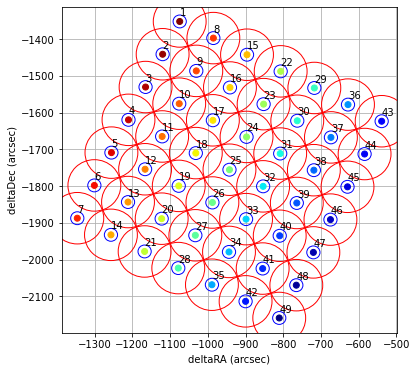

In [9]:
D = 28.047 * millimeter # 27.2 from my drawing
theta = (26.889+90) * deg

delta_ras = np.linspace(-300, 300, 7, endpoint=True) * arcsec
delta_decs = np.linspace(-300, 300, 7, endpoint=True) * arcsec

x, y = np.meshgrid(delta_ras, delta_decs)
xrot = np.zeros(x.shape); yrot = np.zeros(y.shape)
for i in range(len(x)):
        for j in range(len(y)):
            xrot[i,j], yrot[i,j] = np.dot([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]], np.array([x[i,j], y[i,j]]))
delta_ras = xrot.flatten(); delta_decs = yrot.flatten()

nominal_dec = -D * np.sin(theta) * plate_scale
nominal_ra = D * np.cos(theta) * plate_scale / np.cos(obj.dec.rad)
delta_coords = np.array([delta_ras, delta_decs]).T

print('Nominal deltaRA = %.2f arcsec' % (nominal_ra / arcsec))
print('Nominal deltaDec = %.2f arcsec' % (nominal_dec / arcsec))

fig,ax = plt.subplots(figsize=(6,6))
ax.grid(); ax.set_axisbelow(True)
ax.scatter((delta_ras+nominal_ra)/arcsec, (delta_decs+nominal_dec)/arcsec, c=range(len(delta_ras)), cmap='jet_r')
for i in range(len(delta_coords)):
    ax.annotate(str(i+1), ((delta_coords[i][0]+nominal_ra)/arcsec, (delta_coords[i][1]+nominal_dec)/arcsec), textcoords='offset points',
    xytext=(0, 6))
ax.set_xlabel('deltaRA (arcsec)')
ax.set_ylabel('deltaDec (arcsec)')
for i in range(len(delta_coords)):
    circle = plt.Circle(((nominal_ra+delta_coords[i][0])/arcsec, (nominal_dec+delta_coords[i][1])/arcsec), 
        70, color='r', fill=False); ax.add_artist(circle)
    circle = plt.Circle(((nominal_ra+delta_coords[i][0])/arcsec, (nominal_dec+delta_coords[i][1])/arcsec),
        70/4, color='b', fill=False); ax.add_artist(circle)
# ax.set_xlim(0, 64)
# ax.set_ylim(0, 1800)
plt.show()

In [46]:
telescope.SlewToCoordinates(obj_now.ra.hour + ra_offset/hourangle + 0.5*nominal_ra/hourangle, obj_now.dec.deg + dec_offset/deg - 0.1*nominal_dec/deg)

In [11]:
print('Object Coordinates: %s\n\n' % obj_now.to_string('hmsdms'))

for i in range(len(delta_coords)):
    print('Coordinate Pair %i/%i' % ((i+1), len(delta_coords)))
    print('deltaRA     =     %.2f arcsec,  deltaDec = %.2f arcsec' % ((delta_coords[i][0] + nominal_ra) / arcsec, (delta_coords[i][1] + nominal_dec) / arcsec))
    print('Slew Coordinates: %s\n' % coord.SkyCoord(obj.ra.hour + delta_coords[i][0]/hourangle, obj.dec.deg + delta_coords[i][1]/deg, unit=('hour', 'deg')).to_string('hmsdms'))
    telescope.SlewToCoordinates(obj_now.ra.hour + ra_offset/hourangle + nominal_ra/hourangle + delta_coords[i][0]/hourangle, obj_now.dec.deg + dec_offset/deg + nominal_dec/deg + delta_coords[i][1]/deg)
    input('Press Enter to continue...\n')

Object Coordinates: 14h15m38.1769558s +19d10m56.87185517s


Coordinate Pair 1/49
deltaRA     =     -1074.45 arcsec,  deltaDec = -1352.34 arcsec
Slew Coordinates: 14h15m30.87965307s +19d17m39.91734196s

Coordinate Pair 2/49
deltaRA     =     -1119.68 arcsec,  deltaDec = -1441.52 arcsec
Slew Coordinates: 14h15m27.86456315s +19d16m10.72890452s

Coordinate Pair 3/49
deltaRA     =     -1164.91 arcsec,  deltaDec = -1530.71 arcsec
Slew Coordinates: 14h15m24.84947323s +19d14m41.54046708s

Coordinate Pair 4/49
deltaRA     =     -1210.13 arcsec,  deltaDec = -1619.90 arcsec
Slew Coordinates: 14h15m21.83438331s +19d13m12.35202964s

Coordinate Pair 5/49
deltaRA     =     -1255.36 arcsec,  deltaDec = -1709.09 arcsec
Slew Coordinates: 14h15m18.81929339s +19d11m43.1635922s

Coordinate Pair 6/49
deltaRA     =     -1300.58 arcsec,  deltaDec = -1798.28 arcsec
Slew Coordinates: 14h15m15.80420347s +19d10m13.97515476s

Coordinate Pair 7/49
deltaRA     =     -1345.81 arcsec,  deltaDec = -1887.47 arcsec
Slew 

In [48]:
# Make a button to get next coordinate pair and slew telescope to those coordinates
coord_index = 0

button = Button(description='Next Coordinate Pair')
display(button)
print('Object Coordinates: %s\n\n' % obj.to_string('hmsdms'))

def on_button_clicked(b):
    global coord_index

    clear_output()
    display(button)
    print('Object Coordinates: %s\n\n' % obj.to_string('hmsdms'))
    print('Coordinate Pair %i/%i' % ((coord_index+1), len(delta_coords)))
    print('deltaRA     =     %.2f sec,  deltaDec = %.2f arcsec' % (delta_coords[coord_index][0] / secangle, delta_coords[coord_index][1] / arcsec))
    print('Slew Coordinates: %s\n' % coord.SkyCoord(obj.ra.hour + delta_coords[coord_index][0]/hourangle, obj.dec.deg + delta_coords[coord_index][1]/deg, unit=('hour', 'deg')).to_string('hmsdms'))
    telescope.SlewToCoordinates(obj_now.ra.hour + ra_offset/hourangle + delta_coords[coord_index][0]/hourangle, obj_now.dec.deg + dec_offset/deg + delta_coords[coord_index][1]/deg)
    coord_index += 1

button.on_click(on_button_clicked)



Button(description='Next Coordinate Pair', style=ButtonStyle())

Object Coordinates: 14h15m39.6720708s +19d10m56.6729832s




Coordinate Pair 27/49
deltaRA     =     -1033.02 arcsec,  deltaDec = -1933.96 arcsec
Slew Coordinates: 14h15m33.64189096s +19d07m58.29610832s

In [12]:
telescope.SlewToCoordinates(obj_now.ra.hour + ra_offset/hourangle + (-1033.02*arcsec)/hourangle, obj_now.dec.deg + dec_offset/deg + (-1933.96*arcsec)/deg)

Nominal deltaRA = -1033.02 arcsec
Nominal deltaDec = -1933.96 arcsec


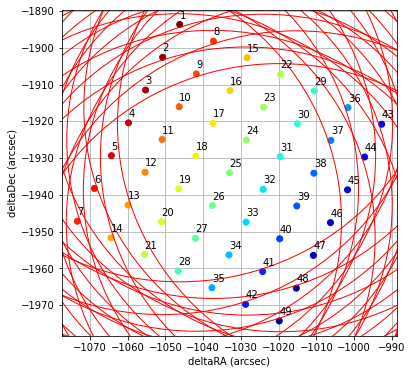

In [17]:
D = 28.047 * millimeter # 27.2 from my drawing
theta = (26.889+90) * deg

delta_ras = np.linspace(-30, 30, 7, endpoint=True) * arcsec
delta_decs = np.linspace(-30, 30, 7, endpoint=True) * arcsec

x, y = np.meshgrid(delta_ras, delta_decs)
xrot = np.zeros(x.shape); yrot = np.zeros(y.shape)
for i in range(len(x)):
        for j in range(len(y)):
            xrot[i,j], yrot[i,j] = np.dot([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]], np.array([x[i,j], y[i,j]]))
delta_ras = xrot.flatten(); delta_decs = yrot.flatten()

nominal_dec = -1933.96*arcsec
nominal_ra = -1033.02*arcsec
delta_coords = np.array([delta_ras, delta_decs]).T

print('Nominal deltaRA = %.2f arcsec' % (nominal_ra / arcsec))
print('Nominal deltaDec = %.2f arcsec' % (nominal_dec / arcsec))

fig,ax = plt.subplots(figsize=(6,6))
ax.grid(); ax.set_axisbelow(True)
ax.scatter((delta_ras+nominal_ra)/arcsec, (delta_decs+nominal_dec)/arcsec, c=range(len(delta_ras)), cmap='jet_r')
for i in range(len(delta_coords)):
    ax.annotate(str(i+1), ((delta_coords[i][0]+nominal_ra)/arcsec, (delta_coords[i][1]+nominal_dec)/arcsec), textcoords='offset points',
    xytext=(0, 6))
ax.set_xlabel('deltaRA (arcsec)')
ax.set_ylabel('deltaDec (arcsec)')
for i in range(len(delta_coords)):
    circle = plt.Circle(((nominal_ra+delta_coords[i][0])/arcsec, (nominal_dec+delta_coords[i][1])/arcsec), 
        70, color='r', fill=False); ax.add_artist(circle)
    '''circle = plt.Circle(((nominal_ra+delta_coords[i][0])/arcsec, (nominal_dec+delta_coords[i][1])/arcsec),
        70/4, color='b', fill=False); ax.add_artist(circle)'''
# ax.set_xlim(0, 64)
# ax.set_ylim(0, 1800)
plt.show()

In [19]:
print('Object Coordinates: %s\n\n' % obj_now.to_string('hmsdms'))

for i in range(len(delta_coords)):
    print('Coordinate Pair %i/%i' % ((i+1), len(delta_coords)))
    print('deltaRA     =     %.2f arcsec,  deltaDec = %.2f arcsec' % ((delta_coords[i][0] + nominal_ra) / arcsec, (delta_coords[i][1] + nominal_dec) / arcsec))
    print('Slew Coordinates: %s\n' % coord.SkyCoord(obj.ra.hour + delta_coords[i][0]/hourangle, obj.dec.deg + delta_coords[i][1]/deg, unit=('hour', 'deg')).to_string('hmsdms'))
    telescope.SlewToCoordinates(obj_now.ra.hour + ra_offset/hourangle + nominal_ra/hourangle + delta_coords[i][0]/hourangle, obj_now.dec.deg + dec_offset/deg + nominal_dec/deg + delta_coords[i][1]/deg)
    input('Press Enter to continue...\n')

Object Coordinates: 14h15m38.1769558s +19d10m56.87185517s


Coordinate Pair 1/49
deltaRA     =     -1046.21 arcsec,  deltaDec = -1893.64 arcsec
Slew Coordinates: 14h15m38.79282903s +19d11m36.99741908s

Coordinate Pair 2/49
deltaRA     =     -1050.73 arcsec,  deltaDec = -1902.55 arcsec
Slew Coordinates: 14h15m38.49132004s +19d11m28.07857533s

Coordinate Pair 3/49
deltaRA     =     -1055.25 arcsec,  deltaDec = -1911.47 arcsec
Slew Coordinates: 14h15m38.18981104s +19d11m19.15973159s

Coordinate Pair 4/49
deltaRA     =     -1059.78 arcsec,  deltaDec = -1920.39 arcsec
Slew Coordinates: 14h15m37.88830205s +19d11m10.24088784s

Coordinate Pair 5/49
deltaRA     =     -1064.30 arcsec,  deltaDec = -1929.31 arcsec
Slew Coordinates: 14h15m37.58679306s +19d11m01.3220441s

Coordinate Pair 6/49
deltaRA     =     -1068.82 arcsec,  deltaDec = -1938.23 arcsec
Slew Coordinates: 14h15m37.28528407s +19d10m52.40320036s

Coordinate Pair 7/49
deltaRA     =     -1073.34 arcsec,  deltaDec = -1947.15 arcsec
Slew 

KeyboardInterrupt: Interrupted by user

Coordinate Pair 26/49
deltaRA     =     -1037.54 arcsec,  deltaDec = -1942.88 arcsec
Slew Coordinates: 14h15m39.37056181s +19d10m47.75413946s